In [125]:
import torch
import inspect
import math
from time import perf_counter
from torchvision import datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch import nn
from torch.nn import functional as F
import dlc_practical_prologue as prologue
import os    
import itertools 
import torch.optim as optim
os.environ['KMP_DUPLICATE_LIB_OK']='True'
%matplotlib inline  

In [13]:
train_input, train_target, train_classes, test_input, test_target, test_classes  = prologue.generate_pair_sets(1000)

In [6]:
def showTensor(aTensor):
    fig = plt.figure(figsize=(5, 5), dpi=20)
    plt.axis('off')
    plt.figure()
    plt.imshow(aTensor.numpy(), cmap='Greys')
    #plt.colorbar()
    plt.show()

In [23]:
test_classes[:, 0]

torch.Size([1000])

In [130]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(2, 16, kernel_size=4)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=4)
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 2)
        # uses BatchNorm cause otherwise the model lose the gradient with higher learning rates
        #self.norm1d = nn.BatchNorm1d(128)
        self.norm2d = nn.BatchNorm2d(16)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=4, stride=1))
        x = self.norm2d(x)
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=4, stride=1))
        x = x.view(-1, 128)
        #x = self.norm1d(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x, x

class Net_classes(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=4)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=4)
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)
        # uses BatchNorm cause otherwise the model lose the gradient with higher learning rates
        #self.norm1d = nn.BatchNorm1d(128)
        self.norm2d = nn.BatchNorm2d(16)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=4, stride=1))
        print(x.size())
        x = self.norm2d(x)
        print(x.size())
        x = F.relu(F.max_pool2d(self.conv2(x), kernel_size=4, stride=1))
        print(x.size())
        x = x.view(-1, 128)
        #x = self.norm1d(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    

class Net_twins(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=4)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=4)
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)
        # uses BatchNorm cause otherwise the model lose the gradient with higher learning rates
        #self.norm1d = nn.BatchNorm1d(128)
        self.norm2d = nn.BatchNorm2d(16)

    def forward(self, x):
        
        x1 = x[:, 0, :, :].unsqueeze_(1)
        x2 = x[:, 1, :, :].unsqueeze_(1)
        
        x1 = F.relu(F.max_pool2d(self.conv1(x1), kernel_size=4, stride=1))
        x1 = self.norm2d(x1)
        x1 = F.relu(F.max_pool2d(self.conv2(x1), kernel_size=4, stride=1))
        x1 = x1.view(-1, 128)
        #x = self.norm1d(x)
        x1 = F.relu(self.fc1(x1))
        x1 = F.relu(self.fc2(x1))
        x1 = self.fc3(x1)
        
        x2 = F.relu(F.max_pool2d(self.conv1(x2), kernel_size=4, stride=1))
        x2 = self.norm2d(x2)
        x2 = F.relu(F.max_pool2d(self.conv2(x2), kernel_size=4, stride=1))
        x2 = x2.view(-1, 128)
        #x = self.norm1d(x)
        x2 = F.relu(self.fc1(x2))
        x2 = F.relu(self.fc2(x2))
        x2 = self.fc3(x2)
        
        return x1, x2
    
#model, criterion = Net(), nn.MSELoss()
#eta, mini_batch_size = 1e-1, 50
#nb_epochs = 10






def train_model(model, train_input,train_target, test_input, test_target, mini_batch_size = 50, 
                nb_epochs = 10, learning_rate = 1e-1, 
                eta = 1e-1, mse = True):
    
    
    train_acc_loss_list = []
    test_acc__loss_list = []
    train_acc = []
    test_acc = []
    if mse == True:
        criterion = nn.MSELoss()
        F.one_hot(train_target).float()
        F.one_hot(test_target).float()
    else:
        criterion = nn.CrossEntropyLoss()
    for e in range(nb_epochs):
        acc_loss = 0
        # We do this with mini-batches
        for b in range(0, train_input.size(0), mini_batch_size):
            output = model(train_input.narrow(0, b, mini_batch_size))
            if mse == True:
                loss = criterion(output, F.one_hot(train_target).float().narrow(0, b, mini_batch_size))
            else:
                loss = criterion(output, train_target.narrow(0, b, mini_batch_size))
            acc_loss = acc_loss + loss.item()

            model.zero_grad()
            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= eta * p.grad
                        

        train_acc_loss_list.append(acc_loss)
                        
        #Chech the accuracy in the train set
        pred = model(train_input).max(1)[1]
        verificar = pred == train_target
        acc = (verificar.sum().item() / train_target.size()[0]) * 100
        train_acc.append(acc)
            
        #Check the accuracy in the test set
        pred = model(test_input).max(1)[1]
        verificar = pred == test_target
        acc = (verificar.sum().item() / test_target.size()[0]) * 100
        test_acc.append(acc)
            
        #Check the loss in the test set
        output = model(test_input)
        if mse == True:
            test_loss = criterion(output, F.one_hot(test_target).float())
        else:
            test_loss = criterion(output, test_target)
        test_acc__loss_list.append(test_loss.item())
            
            
            


    return train_acc_loss_list, test_acc__loss_list, train_acc, test_acc



def train_twins(model, train_input,train_target, test_input, test_target, mini_batch_size = 50, nb_epochs = 10, 
                learning_rate = 1e-1, 
                eta = 1e-1, mse = True):
    
     
    
    x1_target = train_classes[:, 0]
    x2_target = train_classes[:, 1]
    x1_test = train_classes[:, 0]
    x2_test = train_classes[:, 1]
    
    train_acc_loss_list = []
    test_acc__loss_list = []
    train_acc = []
    test_acc = []
    
    
    
    if mse == True:
        criterion = nn.MSELoss()
        F.one_hot(train_target).float()
        F.one_hot(test_target).float()
    else:
        criterion = nn.CrossEntropyLoss()
    for e in range(nb_epochs):
        acc_loss = 0
        # We do this with mini-batches
        
        # Train with the first image
        for b in range(0, train_input.size(0), mini_batch_size):
            output1, output2 = model(train_input.narrow(0, b, mini_batch_size))
            #for output, train_target in (output1, x1_target), (output2, x2_target):
                
            if mse == True:
                loss = criterion(output1, F.one_hot(x1_target,10).float().narrow(0, b, mini_batch_size))
            else:
                loss = criterion(output1, x1_target.narrow(0, b, mini_batch_size))
                acc_loss = acc_loss + loss.item()
                
                
                torch.autograd.set_detect_anomaly(True)
                model.zero_grad()
                loss.backward()
                
                with torch.no_grad():
                    for p in model.parameters():
                        p -= eta * p.grad
                        
                        
        # Train with the seccond image
        for b in range(0, train_input.size(0), mini_batch_size):
            output1, output2 = model(train_input.narrow(0, b, mini_batch_size))
            #for output, train_target in (output1, x1_target), (output2, x2_target):
                
            if mse == True:
                loss = criterion(output2, F.one_hot(x1_target,10).float().narrow(0, b, mini_batch_size))
            else:
                loss = criterion(output1, x1_target.narrow(0, b, mini_batch_size))
                acc_loss = acc_loss + loss.item()
                
                
                model.zero_grad()
                loss.backward()
                
                
                with torch.no_grad():
                    for p in model.parameters():
                        p -= eta * p.grad
                        
                        
            
                        
        train_acc_loss_list.append(acc_loss)
                        
        #Chech the accuracy in the train set
        pred1, pred2 = model(train_input)
        pred = pred1.max(1)[1] <= pred2.max(1)[1]
        verificar = sum(pred == train_target)
        acc = (verificar.sum().item() / train_target.size()[0]) * 100
        train_acc.append(acc)
            
        #Check the accuracy in the test set
        pred1, pred2 = model(test_input)
        pred = pred1.max(1)[1] <= pred2.max(1)[1]
        verificar = sum(pred == test_target)
        acc = (verificar.sum().item() / test_target.size()[0]) * 100
        test_acc.append(acc)
            
        #Check the loss in the test set
        #output = model(test_input)
        #if mse == True:
            #test_loss = criterion(output, F.one_hot(test_target).float())
        #else:
            #test_loss = criterion(output, test_target)
        #test_acc__loss_list.append(test_loss.item())
            
            
            


    return train_acc_loss_list, train_acc, test_acc



[65.4, 79.9, 91.3, 94.3, 94.39999999999999, 96.89999999999999, 97.5, 97.7, 97.5, 97.5, 97.6, 97.6, 97.5, 97.5, 97.5, 97.5, 97.5, 97.5, 97.5, 97.5, 97.5, 97.5, 97.5, 97.5, 97.5, 97.5, 97.5, 97.5, 97.5, 97.5, 97.5, 97.5, 97.5, 97.5, 97.5, 97.5, 97.5, 97.5, 97.5, 97.5, 97.5, 97.39999999999999, 97.39999999999999, 97.39999999999999, 97.39999999999999, 97.39999999999999, 97.39999999999999, 97.39999999999999, 97.39999999999999, 97.39999999999999]
[68.5, 80.7, 90.9, 93.5, 93.60000000000001, 94.89999999999999, 95.5, 95.6, 95.6, 95.6, 95.6, 95.8, 95.8, 95.6, 95.6, 95.6, 95.6, 95.6, 95.6, 95.6, 95.6, 95.6, 95.6, 95.5, 95.5, 95.5, 95.5, 95.5, 95.5, 95.5, 95.5, 95.5, 95.5, 95.5, 95.5, 95.5, 95.5, 95.5, 95.5, 95.5, 95.5, 95.5, 95.5, 95.5, 95.5, 95.5, 95.5, 95.5, 95.5, 95.5]


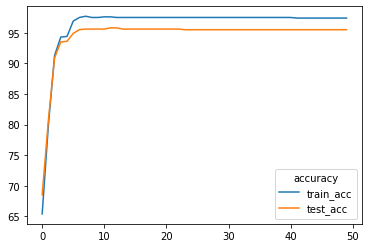

In [132]:

model = Net_twins()




train_acc_loss_list, train_acc, test_acc =train_twins(model, train_input,train_target, 
                                                      test_input, test_target, mini_batch_size = 50, nb_epochs = 50, 
                                                      learning_rate = 1e-1, 
                                                      eta = 1e-1, mse = True)



print(train_acc)
print(test_acc)
plt.plot(train_acc, label = "train_acc")
plt.plot(test_acc, label = "test_acc")
plt.legend(title='accuracy')
plt.show()


In [115]:
pred1, pred2 = model(test_input)
pred = pred1.max(1)[1] <= pred2.max(1)[1]
sum(pred == test_target)





tensor(966)

In [113]:





y1 = test_classes[:,0] <= test_classes[:,1]
sum(y1 == test_target)

tensor(1000)

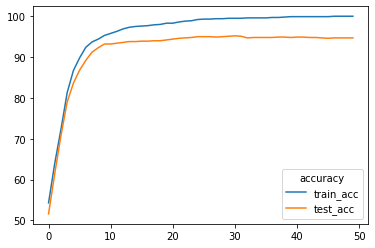

In [56]:

model = Net_classes()

img1_train = train_input[:, 0, :, :].unsqueeze_(1)
class_train_target = train_classes[:, 0]

img1_test = test_input[:, 0, :, :].unsqueeze_(1)
class_test_target = test_classes[:, 0]

_, _, train_acc, test_acc = train_model(model, 
                                        train_input = img1_train,
                                        train_target = class_train_target, 
                                        test_input = img1_test, 
                                        test_target = class_test_target, 
                                        mini_batch_size = 10, 
                                        nb_epochs = 50, 
                                        learning_rate = 1e-1, 
                                        eta = 1e-1, 
                                        mse = True)

plt.plot(train_acc, label = "train_acc")
plt.plot(test_acc, label = "test_acc")
plt.legend(title='accuracy')
plt.show()



[38.0, 56.10000000000001, 68.30000000000001, 78.5, 85.9, 89.2, 92.0, 93.5, 94.3, 95.19999999999999, 95.5, 96.1, 96.5, 97.2, 97.8, 98.1, 98.4, 98.6, 98.7, 98.9, 98.9, 99.1, 99.1, 99.1, 99.2, 99.3, 99.4, 99.4, 99.4, 99.4, 99.5, 99.6, 99.6, 99.7, 99.7, 99.7, 99.8, 99.8, 99.8, 99.8, 99.8, 99.8, 99.8, 99.8, 99.9, 99.9, 99.9, 99.9, 99.9, 99.9]
[35.4, 52.400000000000006, 65.3, 75.2, 82.8, 86.2, 88.3, 89.7, 91.10000000000001, 91.9, 92.9, 93.10000000000001, 93.2, 93.2, 93.7, 93.60000000000001, 94.1, 94.69999999999999, 94.69999999999999, 94.69999999999999, 94.8, 94.69999999999999, 94.8, 94.8, 94.89999999999999, 94.89999999999999, 94.89999999999999, 94.89999999999999, 94.89999999999999, 94.8, 94.89999999999999, 94.89999999999999, 94.89999999999999, 95.0, 95.0, 95.1, 95.1, 95.1, 94.89999999999999, 94.69999999999999, 94.69999999999999, 94.69999999999999, 94.69999999999999, 94.69999999999999, 94.69999999999999, 94.69999999999999, 94.69999999999999, 94.69999999999999, 94.69999999999999, 94.6]


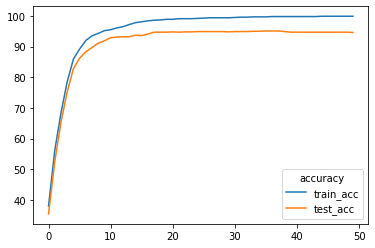

In [51]:
plt.plot(train_acc, label = "train_acc")
plt.plot(test_acc, label = "test_acc")
plt.legend(title='accuracy')
plt.show()

In [8]:
output1, output2 = model(train_input)

In [10]:
output2

tensor([[0.1604, 0.1205],
        [0.1456, 0.1554],
        [0.1712, 0.1313],
        ...,
        [0.0910, 0.0668],
        [0.1580, 0.1209],
        [0.0888, 0.0898]], grad_fn=<AddmmBackward0>)

In [19]:
print(train_input[:, 0, :, :].size())  # All first pair
print(train_input[:, 0, :, :].unsqueeze_(1).size())

torch.Size([1000, 14, 14])
torch.Size([1000, 1, 14, 14])


In [32]:
model = Net_classes()
img1 = train_input[:, 0, :, :].unsqueeze_(1)
model(img1)

tensor([[ 0.2152, -0.0063,  0.1182,  ...,  0.0486,  0.1529,  0.0439],
        [ 0.2613,  0.0689,  0.0730,  ...,  0.1259,  0.1625,  0.0596],
        [ 0.2798,  0.0427,  0.1269,  ...,  0.1104,  0.1724,  0.0689],
        ...,
        [ 0.2466,  0.0691,  0.1060,  ...,  0.1001,  0.1741,  0.0561],
        [ 0.2739,  0.0711,  0.1271,  ...,  0.0949,  0.1810,  0.0391],
        [ 0.2298,  0.0547,  0.1310,  ...,  0.1076,  0.1968,  0.0741]],
       grad_fn=<AddmmBackward0>)

In [28]:
train_input.size()

torch.Size([1000, 2, 14, 14])

In [29]:
train_input[:, 0, :, :].unsqueeze_(1).size()

torch.Size([1000, 1, 14, 14])

In [55]:
x1 = 1
x2 = 2
x3 = 3
x4 = 4

for i,j in (x1, x2), (x3,x4):
    print (i,j)



1 2
3 4


In [70]:
model = Net_classes()
model(train_input[:, 0, :, :].unsqueeze_(1))

torch.Size([1000, 16, 8, 8])
torch.Size([1000, 16, 8, 8])
torch.Size([1000, 32, 2, 2])


tensor([[-0.0293,  0.0981, -0.0103,  ..., -0.1808,  0.0090, -0.0733],
        [-0.0163,  0.0703,  0.0496,  ..., -0.1372, -0.0012, -0.0797],
        [-0.0707,  0.0683, -0.0657,  ..., -0.2153,  0.0741, -0.1617],
        ...,
        [-0.0343,  0.0652, -0.0061,  ..., -0.1710, -0.0032, -0.0749],
        [-0.0637,  0.0587, -0.0483,  ..., -0.2123,  0.0620, -0.1782],
        [-0.0867,  0.0770, -0.0674,  ..., -0.2652,  0.0900, -0.1957]],
       grad_fn=<AddmmBackward0>)

In [91]:
model = Net_twins()

x1 = train_input[:, 0, :, :].unsqueeze_(1)
x2 = train_input[:, 1, :, :].unsqueeze_(1)

model(train_input)

torch.Size([1000, 1, 14, 14])
torch.Size([1000, 1, 14, 14])
torch.Size([1000, 16, 8, 8])
torch.Size([1000, 16, 8, 8])
torch.Size([1000, 32, 2, 2])


(tensor([[ 0.2032, -0.1717, -0.1775,  ...,  0.0801,  0.1910, -0.1152],
         [ 0.1571, -0.1572, -0.1450,  ...,  0.0620,  0.1475, -0.1265],
         [ 0.1773, -0.1808, -0.1307,  ...,  0.0330,  0.1482, -0.1022],
         ...,
         [ 0.1810, -0.1770, -0.1765,  ...,  0.0635,  0.1679, -0.0998],
         [ 0.1900, -0.2336, -0.1721,  ...,  0.0687,  0.1647, -0.1266],
         [ 0.2097, -0.1336, -0.2026,  ...,  0.1203,  0.2410, -0.0961]],
        grad_fn=<AddmmBackward0>),
 tensor([[ 0.1619, -0.1707, -0.1273,  ...,  0.0478,  0.1331, -0.1016],
         [ 0.1312, -0.1878, -0.0963,  ...,  0.0402,  0.0846, -0.1124],
         [ 0.2126, -0.1492, -0.1727,  ...,  0.1029,  0.2189, -0.1289],
         ...,
         [ 0.1864, -0.1400, -0.1655,  ...,  0.0587,  0.1781, -0.0935],
         [ 0.1194, -0.1853, -0.0783,  ...,  0.0564,  0.0816, -0.1139],
         [ 0.1768, -0.1677, -0.1407,  ...,  0.0479,  0.1600, -0.0970]],
        grad_fn=<AddmmBackward0>))